### Deep Diving Time Confound
Confused about this result, particularly middle component
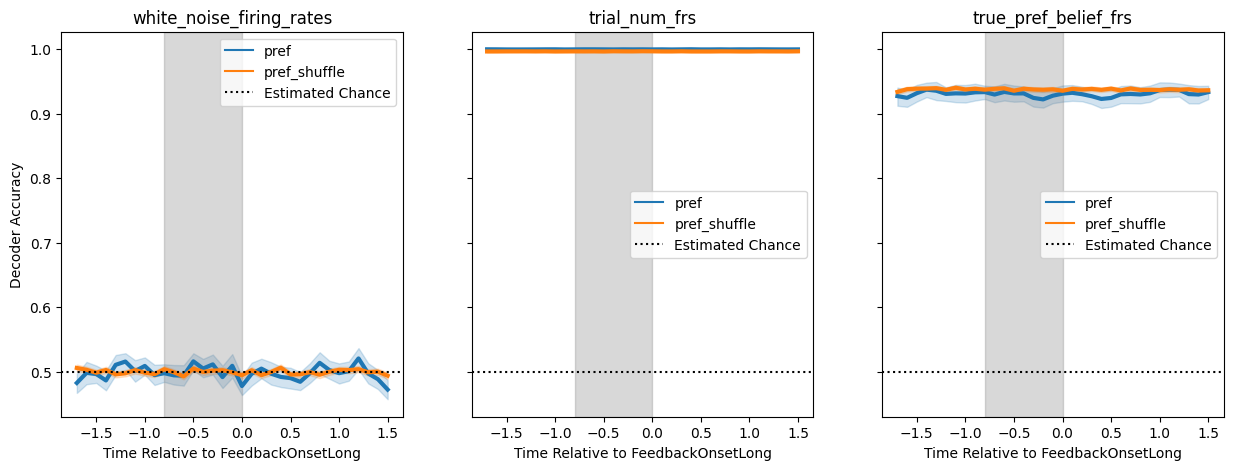

See if we can simplify setup and debug a bit, just look at one session, with trial number as firing rates, an run decoding

### Imports

In [12]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils
import utils.behavioral_utils as behavioral_utils

from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants for the notebook

In [14]:
subject = "SA"
session = "20180802"

pre_interval = 1800
post_interval = 1500
event = "FeedbackOnset"
interval_size = 100

### Load behavioral data for one session, examine behavioral data
Just load Sam, 20180802 first and see

In [2]:


beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, session)

What's the number of blocks per rule in this session

In [3]:
beh.groupby("CurrentRule").BlockNumber.nunique()

CurrentRule
CIRCLE      6
CYAN        6
ESCHER      1
GREEN       6
MAGENTA     3
POLKADOT    4
RIPPLE      4
SQUARE      5
STAR        2
SWIRL       4
TRIANGLE    7
YELLOW      5
Name: BlockNumber, dtype: int64

Seems like a lot of blocks of TRIANGLE, how are the trials where TRIANGLE is preferred distributed across the session?

Text(0.5, 0, 'Trial Number')

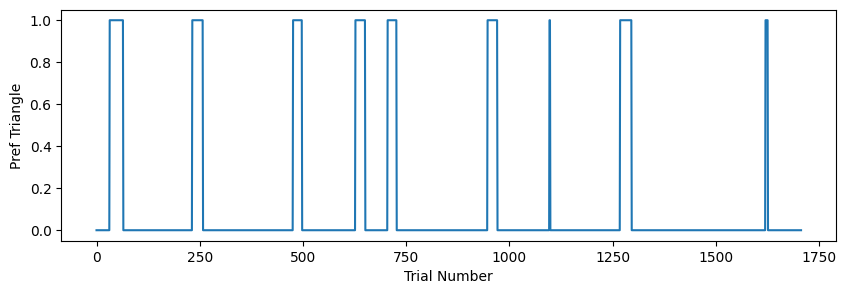

In [4]:
pref_triangle = beh.PreferredBelief.apply(lambda x: 1 if x == "TRIANGLE" else 0)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pref_triangle)
ax.set_ylabel("Pref Triangle")
ax.set_xlabel("Trial Number")

### Now load the firing rates, replace with trial number

In [15]:
spikes_path = io_utils.SESS_SPIKES_PATH.format(
    sub=subject,
    sess_name=session, 
    fr_type="firing_rates",
    pre_interval=pre_interval, 
    event=event, 
    post_interval=post_interval, 
    interval_size=interval_size,
)
frs = pd.read_pickle(spikes_path)

In [6]:
frs

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,0.0,1.308107
1,0,0,0.1,0.0,6.553153
2,0,0,0.2,2.0,16.406473
3,0,0,0.3,3.0,22.726984
4,0,0,0.4,2.0,21.158603
...,...,...,...,...,...
2654977,1749,45,2.8,0.0,0.539911
2654978,1749,45,2.9,0.0,2.419714
2654979,1749,45,3.0,1.0,3.989435
2654980,1749,45,3.1,0.0,2.421053


In [7]:
trial_num_frs = spike_utils.trial_num_as_frs(frs)

In [8]:
trial_num_frs

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,0.0,0
1,0,0,0.1,0.0,0
2,0,0,0.2,2.0,0
3,0,0,0.3,3.0,0
4,0,0,0.4,2.0,0
...,...,...,...,...,...
2654977,1749,45,2.8,0.0,1749
2654978,1749,45,2.9,0.0,1749
2654979,1749,45,3.0,1.0,1749
2654980,1749,45,3.1,0.0,1749


### Set up a decoding run: 

In [9]:
pref_beh = behavioral_utils.get_chosen_preferred_single("TRIANGLE", beh)
pref_beh = behavioral_utils.balance_trials_by_condition(pref_beh, ["Choice"])

/src/wcst_decode/utils/behavioral_utils.py:756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_feat_pref["Choice"] = feat
/src/wcst_decode/utils/behavioral_utils.py:762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chose_other["Choice"] = "other"


Text(0.5, 0, 'Trial Number')

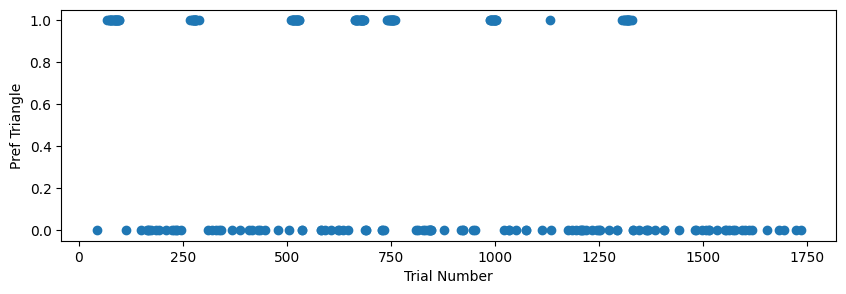

In [10]:
pref_triangle = pref_beh.PreferredBelief.apply(lambda x: 1 if x == "TRIANGLE" else 0)
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(pref_beh.TrialNumber, pref_triangle)
ax.set_ylabel("Pref Triangle")
ax.set_xlabel("Trial Number")

In [11]:
trial_num_frs = trial_num_frs.rename(columns={"FiringRate": "Value"})
splitter = ConditionTrialSplitter(pref_beh, "Choice", test_ratio=0.2)
session_data = SessionData(session, pref_beh, trial_num_frs, splitter)
splits = session_data.pre_generate_splits(8)
sess_datas = pd.Series([session_data])

### Decode

In [13]:
classes = ["TRIANGLE", "other"]
num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
# create a trainer object
trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=1000)
# create a wrapper for the decoder
model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

# calculate time bins (in seconds)
time_bins = np.arange(0, (post_interval + pre_interval) / 1000, interval_size / 1000)
train_accs, test_accs, shuffled_accs, models = pseudo_classifier_utils.evaluate_classifiers_by_time_bins(
    model, sess_datas, time_bins, NUM_SPLITS, NUM_TRAIN_PER_COND, NUM_TEST_PER_COND
)

cuda
Working on bin 0.0
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.1
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.2
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.30000000000000004
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.4
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.5
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.6000000000000001
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Fitting model
Working on bin 0.7000000000000001
Fitting model

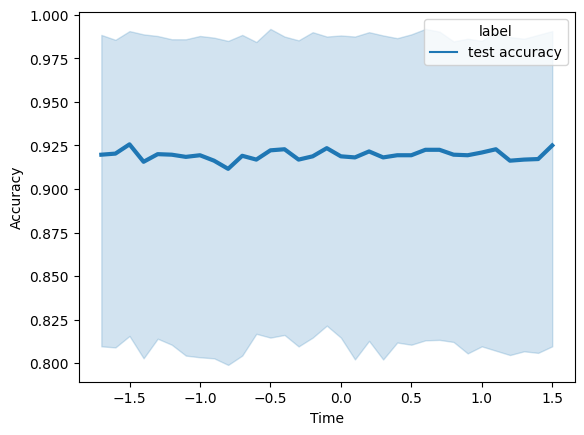

In [17]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn([test_accs], ["test accuracy"], pre_interval, interval_size, ax)